
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P1_SARSA_and_QLearning.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P1_SARSA_and_QLearning.ipynb)

# **HW2: SARSA(n) and Q-Learning(n)**
---


> - Full Name: **Parsa Ghezelbash**
> - Student ID: **401110437**

## **Overview**  

In this notebook, we will experiment with different reinforcement learning algorithms under various configurations to gain deeper insights into their behavior.  

By completing this homework, you will:  
- Understand **exploration vs. exploitation** and how they impact the learning process in an environment.  
- Learn how to **balance exploration and exploitation** effectively for optimal performance.  
- Recognize the importance of **epsilon decay** and when to use.  

Also, you will:  
- Gain a solid understanding of **n-step SARSA** and **n-step Q-learning**.  
- Explore how different values of **n** affect learning quality and efficiency.  
- Compare the strengths and trade-offs of **n-step SARSA vs. n-step Q-learning** to determine when to use each method.

---

We will start by learning how to implement **epsilon-greedy**, **n-step SARSA**, and **n-step Q-learning**.  

Next, we will implement a class that takes learning **hyperparameters** and includes a `learn` method, which accepts an algorithm (such as SARSA) and trains the environment accordingly.  

After that, we will experiment with **different epsilon values** to analyze their effect on the learning process. Finally, we will explore **different values of n** to gain deeper insights into **n-step SARSA** and **n-step Q-learning** and their impact on learning quality.


## **Environment Setup**
Setting up required libraries and environment.

In [ ]:
!sudo apt-get update --quiet
!pip install 'imageio==2.4.0' --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip3 install gymnasium[classic_control] --quiet

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state informat

In [ ]:
import gymnasium as gym
import random
import base64
import imageio
import IPython
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve as conv
from collections import defaultdict

In [ ]:
# @title helper and plotting functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1, fps=5, max_steps=48):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, _ = env.reset()
            video.append_data(env.render())
            while max_steps >= 0:
                action = policy(state, Q)
                state, _, terminated, truncated, _ = env.step(action)
                max_steps -= 1
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_heatmap(env, value, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        _, ax = plt.subplots()
    dim_x, dim_y = 12, 4
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    labels[37:-1], labels[-1] = ' ', 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
    if show:
        plt.show()
    return im


def plot_rewards(rewards, average_range=10, log=False, ax=None, show=False):
    # Generate plot showing total reward accumulated in each episode.
    n_episodes = len(rewards)
    if log:
        rewards = np.log10(-rewards)
    if ax is None:
        fig, ax = plt.subplots()
    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
    ax.plot(range(0, n_episodes, average_range), smoothed_rewards[0:n_episodes:average_range])
    ylab = 'Log of negative sum of rewards' if log else 'Total reward'
    ax.set(xlabel='Episodes', ylabel=ylab)
    if show:
      plt.show()


def plot_performance(env, value, reward_sums, log=False):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
    plot_rewards(reward_sums, ax=axes[0], log=log)
    plot_heatmap(env, value, ax=axes[1])
    plt.show(fig)

def plot_regret(regret_sums, average_range=10, ax=None, show=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(np.cumsum(regret_sums), color='orange', label="Cumulative Regret")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Cumulative Regret")
    ax.set_title("Regret Over Time")
    ax.legend()
    ax.grid()

    if show:
        plt.show()

    return ax

In [ ]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()

print('Observations:',env.observation_space )
print('Actions:',env.action_space )

Observations: Discrete(48)
Actions: Discrete(4)


## **Policy Definitions**
Implementing different policies for action selection.[link text](https://)

In [ ]:
Actions =[0,1,2,3]


def random_policy(state = None,Q = None):
    action = env.action_space.sample()

    return  action

In [ ]:
create_policy_eval_video(env = env, policy = random_policy,filename='random', max_steps=50)

In [ ]:
import numpy as np

def greedy_policy(state, Q):
    """Greedy policy: selects the maximum value action.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)

    Returns:
      action (integer): the chosen action
    """
    return np.argmax(Q[state])


In [ ]:
def epsilon_greedy(state, Q, epsilon = 0.1):
    """Epsilon-greedy policy: selects the maximum value action with probabilty
        (1-epsilon) and selects randomly with epsilon probability.


    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)
      epsilon (float): probability of selecting an action randomly

    Returns:
      action (integer): the chosen action
    """
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return greedy_policy(state,Q)


## **Evaluation & Visualization**
Analyzing policy performance.

In [ ]:
def evaluate_policy(env, Q, num_episodes=1, max_steps=100):
    sum_rewards = 0
    state, _ = env.reset()

    for e in range(num_episodes):
        for s in range(max_steps):
            action = greedy_policy(state, Q)
            state, reward, terminated, truncated, _ = env.step(action)
            sum_rewards += reward
            if terminated or truncated:
                break

    return np.mean(sum_rewards), np.std(sum_rewards)

In [ ]:
from collections import deque
class learnEnvironment:
  def __init__(self, env, episodes, n, alpha, max_step, epsilon=0.1, discount=0.95):
    self.n = n
    self.episodes = episodes
    self.Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    self.Return_list = []
    self.alpha = alpha
    self.discount = discount
    self.max_step = max_step
    self.epsilon = epsilon

  def learn(self, env, learning_rule, epsilon_greedy_policy):
      for episode in range(self.episodes):
        t = 0
        Return = 0
        n_step_reward = deque([], n)
        state, _ = env.reset()
        states = deque([], n)
        actions = deque([], n)
        done = False
        while True:

          action = epsilon_greedy_policy(state, self.Q_table, self.epsilon)
          states.append(state)
          actions.append(action)
          next_state, reward, terminated, truncated, info = env.step(action)
          Return += reward

          if terminated or truncated or t > self.max_step:
            self.Return_list.append(Return)
            break

          n_step_reward.append(reward)
          T =  t - self.n + 1
          if T >= 0:
              self.Q_table = learning_rule(n_step_reward, self.Q_table, states, actions, next_state, self.discount, self.n, self.alpha)
          t += 1
          state = next_state

      return self.Q_table, self.Return_list

In [ ]:
#@title N-step Sarsa_algortihm
def calculate_n_step_Return(n_step_reward, discount = 0.95):
  G = 0
  for r in reversed(n_step_reward):
    G = discount*G + r

  return G

def sarsa(n_step_reward, Q, states, actions, next_state, discount, n, alpha, epsilon=0.1):
    """SARSA: updates the value function and returns it.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      params (dict): a dictionary containing the default parameters

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    G = calculate_n_step_Return(n_step_reward, discount)
    G += discount**n * Q[next_state, epsilon_greedy(next_state, Q, epsilon)]
    td_error = G - Q[states[0], actions[0]]

    Q[states[0], actions[0]] += alpha * td_error

    return Q

In [ ]:
#@title N-step Q-learning_algortihm

def n_step_q_learning(n_step_reward, Q, states, actions, next_state, discount, n, alpha):
    """
    N-step Q-learning: updates the value function (Q) and returns it.

    Args:
      n_step_reward (list): the list of rewards collected over n steps
      Q (ndarray): current value function of shape (n_states, n_actions)
      state (int): the original state from which the first action was taken
      action (int): the action taken at the original state
      next_state (int): the resulting state after n steps
      discount (float): discount factor (gamma)
      n (int): number of steps
      alpha (float): learning rate

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    G = calculate_n_step_Return(n_step_reward, discount)
    G += discount**n * np.max(Q[next_state])
    td_error = G - Q[states[0], actions[0]]

    Q[states[0], actions[0]] += alpha * td_error

    return Q

# **Exploration vs. Exploitation Trade-off**
In reinforcement learning, an agent must balance between:
- **Exploration**: Trying new actions to discover potentially better long-term rewards.
- **Exploitation**: Choosing the best-known action based on current knowledge to maximize immediate reward.

### **Why is this Trade-off Important?**
- Too much **exploration** → The agent wastes time taking suboptimal actions and miss the optimal reward.
- Too much **exploitation** → The agent might **get stuck in a suboptimal policy** without discovering new possibilities for a better strategy.

### **Epsilon-Greedy Policy**:  
   - With probability $\epsilon$, the agent **explores** (chooses a random action).  
   - With probability $\epsilon$, the agent **exploits** (chooses the best-known action).  
   - $\epsilon$ is often **decayed over time** to gradually shift from exploration to exploitation.

---

# **Regret in Reinforcement Learning**
Regret in reinforcement learning measures the **difference between the reward an agent actually receives** and the **maximum possible reward it could have received** under an optimal policy. It quantifies **learning inefficiency** and helps evaluate how well an agent balances exploration and exploitation.

### **Mathematical Definition**
Given:
- $R_t^{\text{optimal}}$ is the reward the agent **could have obtained** in timestep \( t \) under the optimal policy.
- $R_t$ is the **actual reward** obtained by the agent in timestep \( t \).

The **instantaneous regret** at time \( t \) is:

$$
\text{Regret}(t) = R_t^{\text{optimal}} - R_t
$$

The **cumulative regret** over \( T \) timesteps is:

$$
\text{Cumulative Regret}(T) = \sum_{t=1}^{T}  ( R_t^{\text{optimal}} - R_t)
$$
A well-trained RL agent should aim to **minimize regret** over time.

---






SARSA mean_reward = -17.00 +/- 0.0000



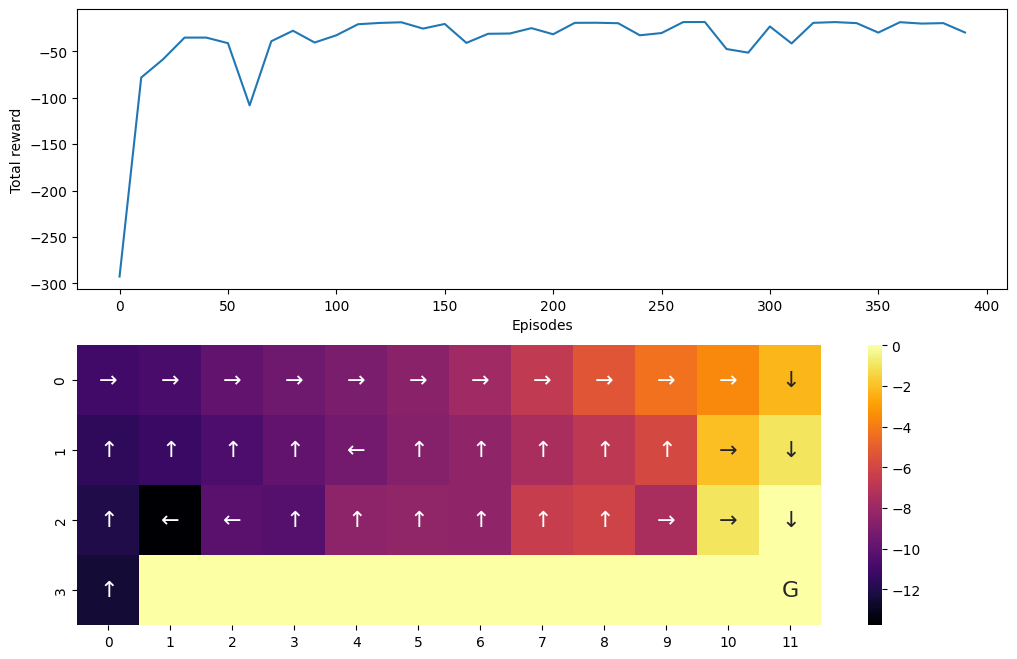

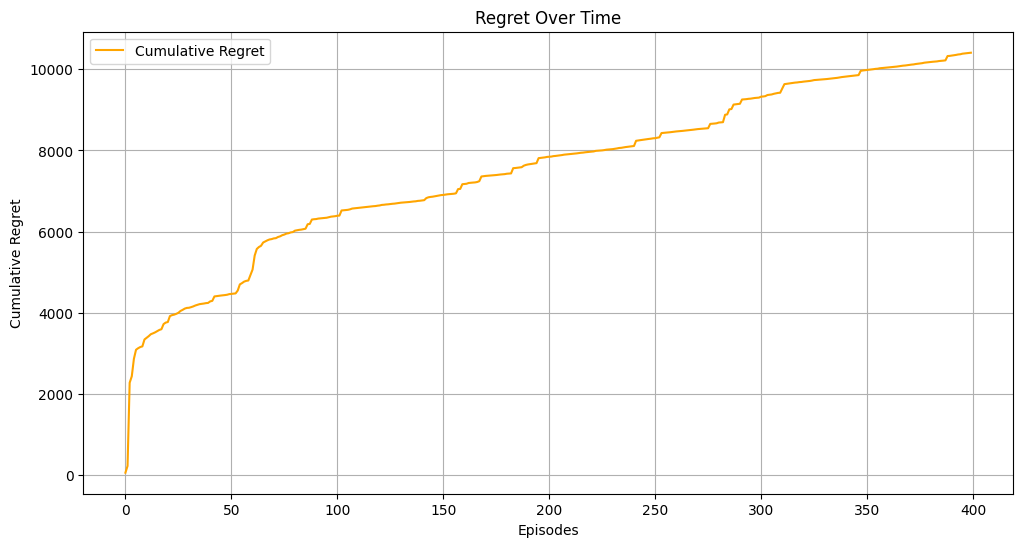

<Axes: title={'center': 'Regret Over Time'}, xlabel='Episodes', ylabel='Cumulative Regret'>

In [ ]:
# @title epsilon = 0.1
optimal_reward = -13

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)



# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = []

# Compute regret for each episode
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot regret
plot_regret(regret_sums_sarsa, show=True)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


SARSA mean_reward = -15.00 +/- 0.0000



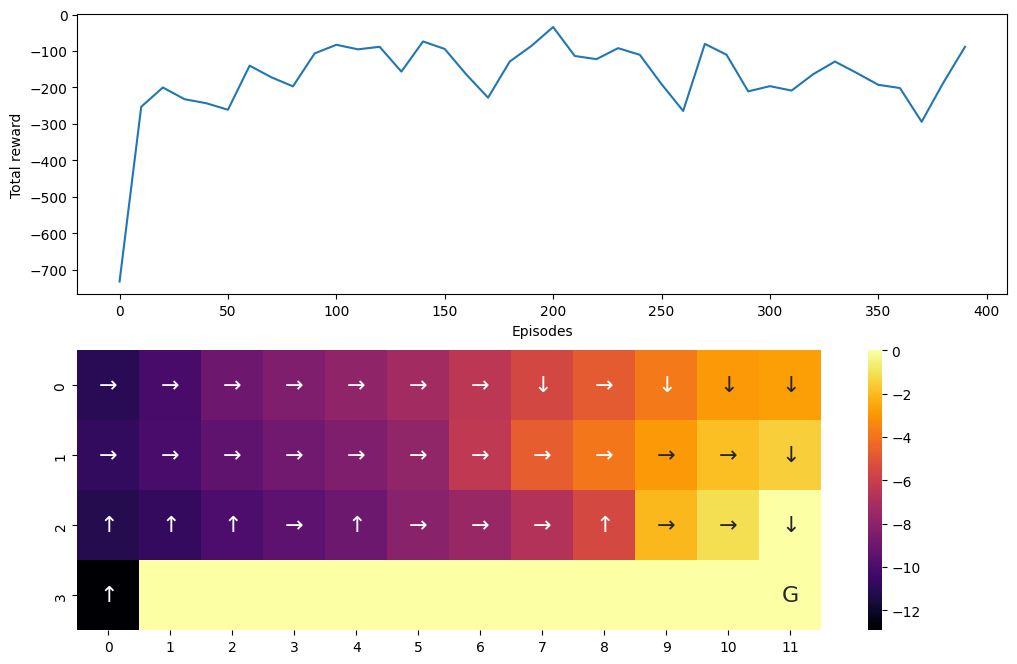

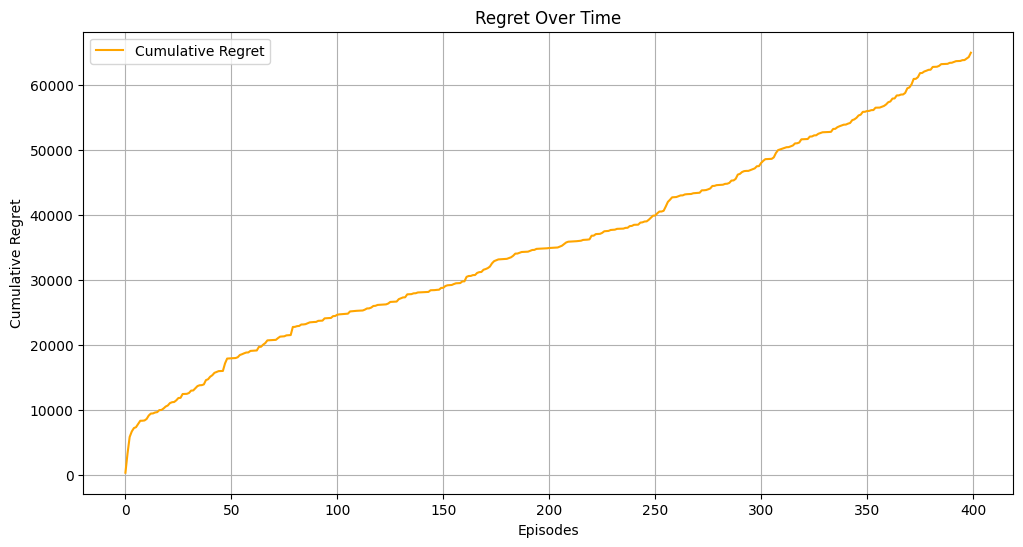

In [ ]:
# @title epsilon = 0.5
optimal_reward = -13

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.5)



# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = []

# Compute regret for each episode
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot regret
plot_regret(regret_sums_sarsa, show=True)


# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



SARSA mean_reward = -15.00 +/- 0.0000



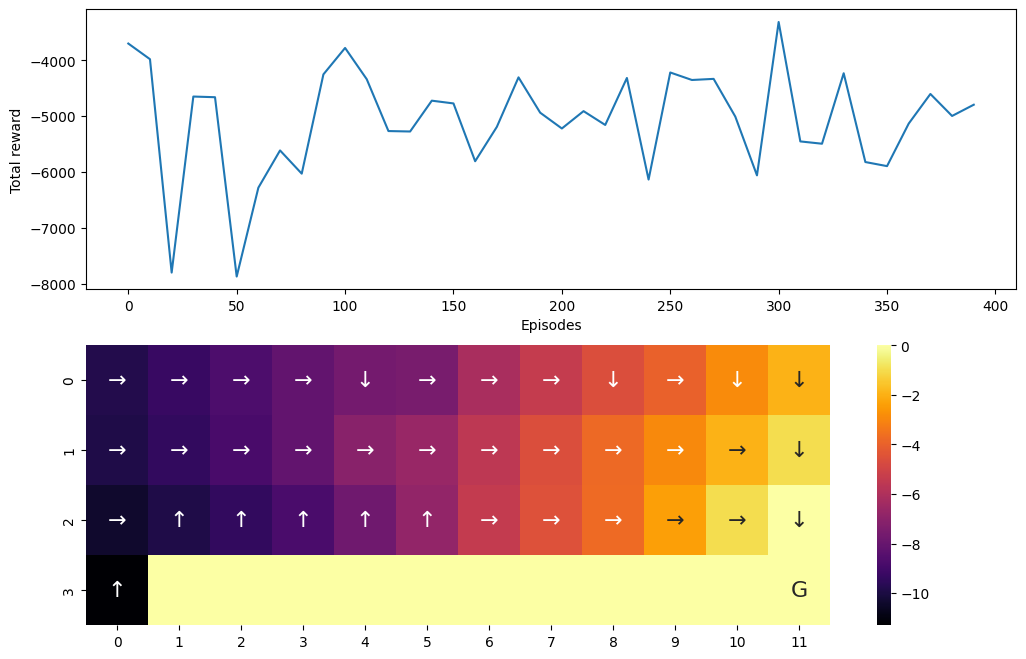

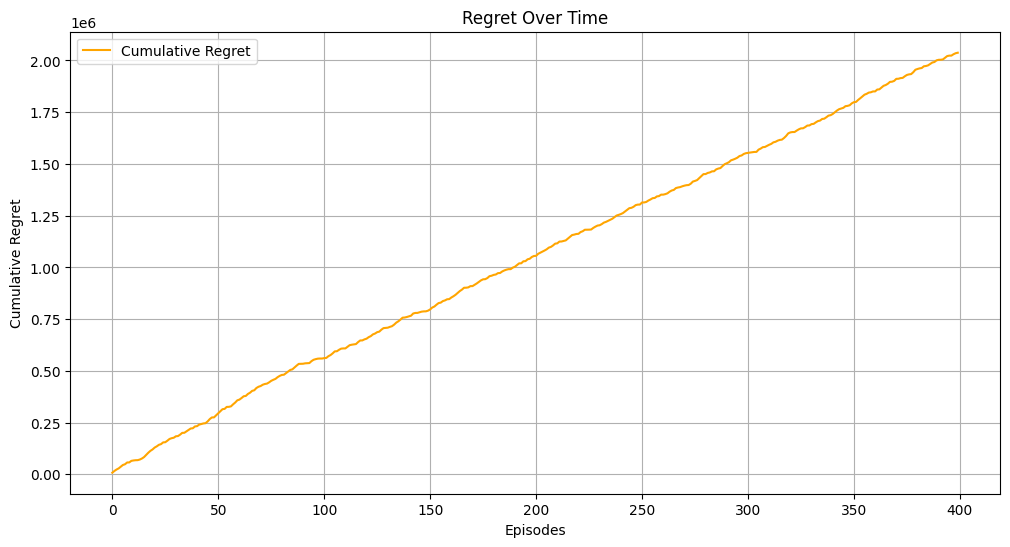

In [ ]:
# @title epsilon = 0.9
optimal_reward = -13

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.9)



# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = []

# Compute regret for each episode
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot regret
plot_regret(regret_sums_sarsa, show=True)


# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


Fast Decay


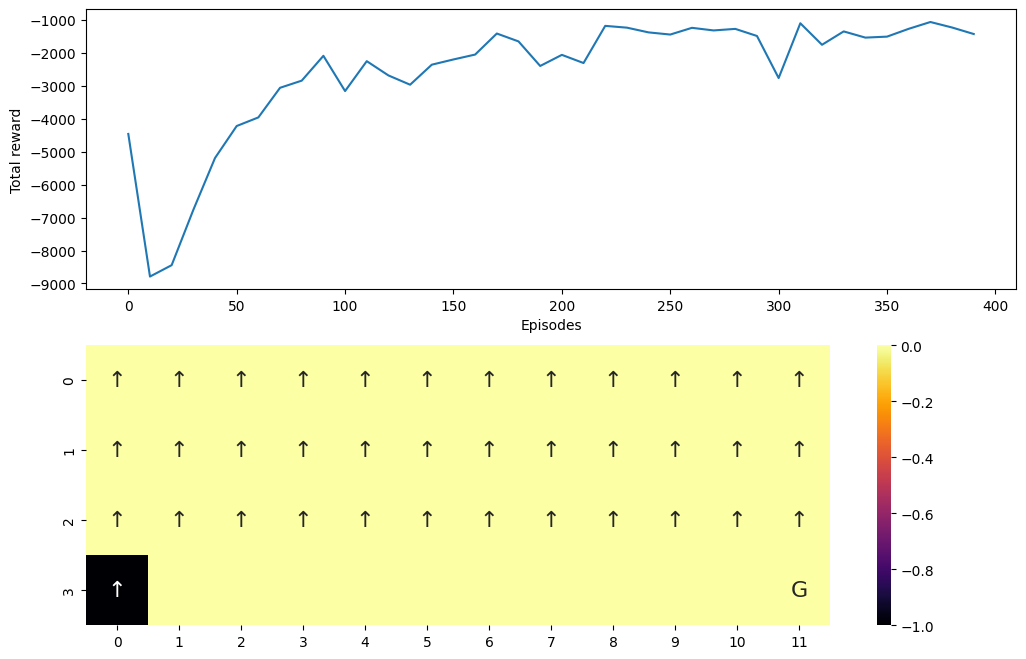


Fast Decay SARSA mean_reward = -100.00 +/- 0.0000
Medium Decay


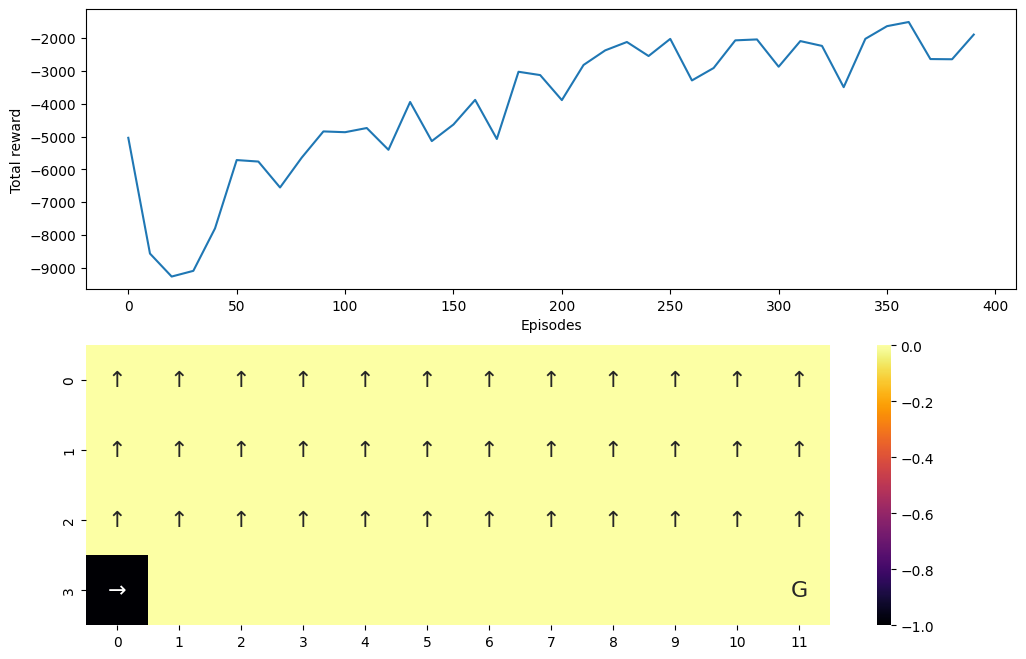


Medium Decay SARSA mean_reward = -10000.00 +/- 0.0000
Slow Decay


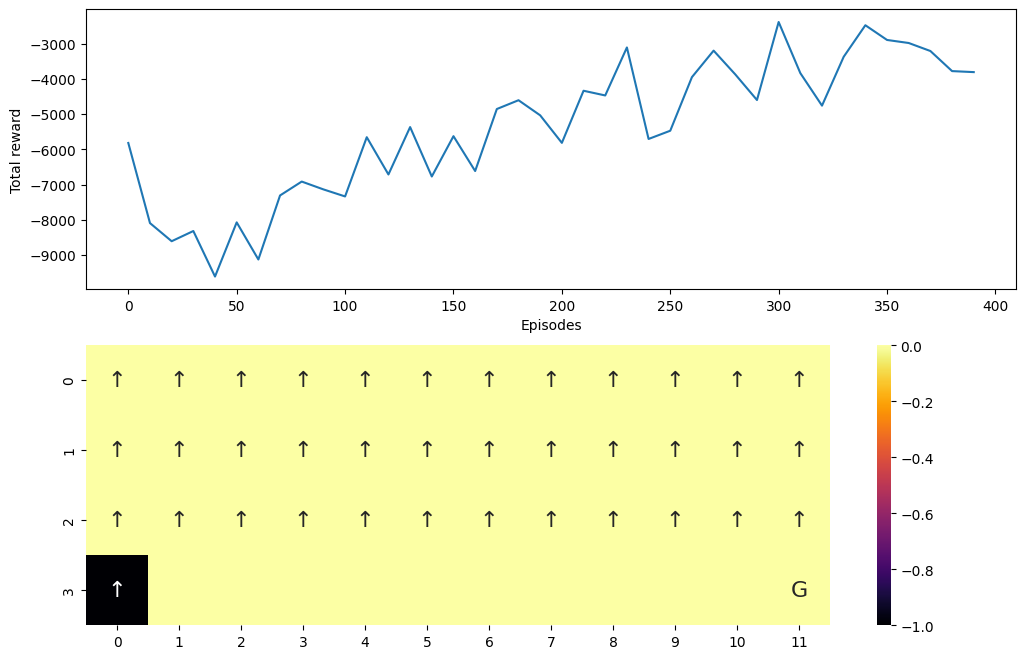


Slow Decay SARSA mean_reward = -100.00 +/- 0.0000


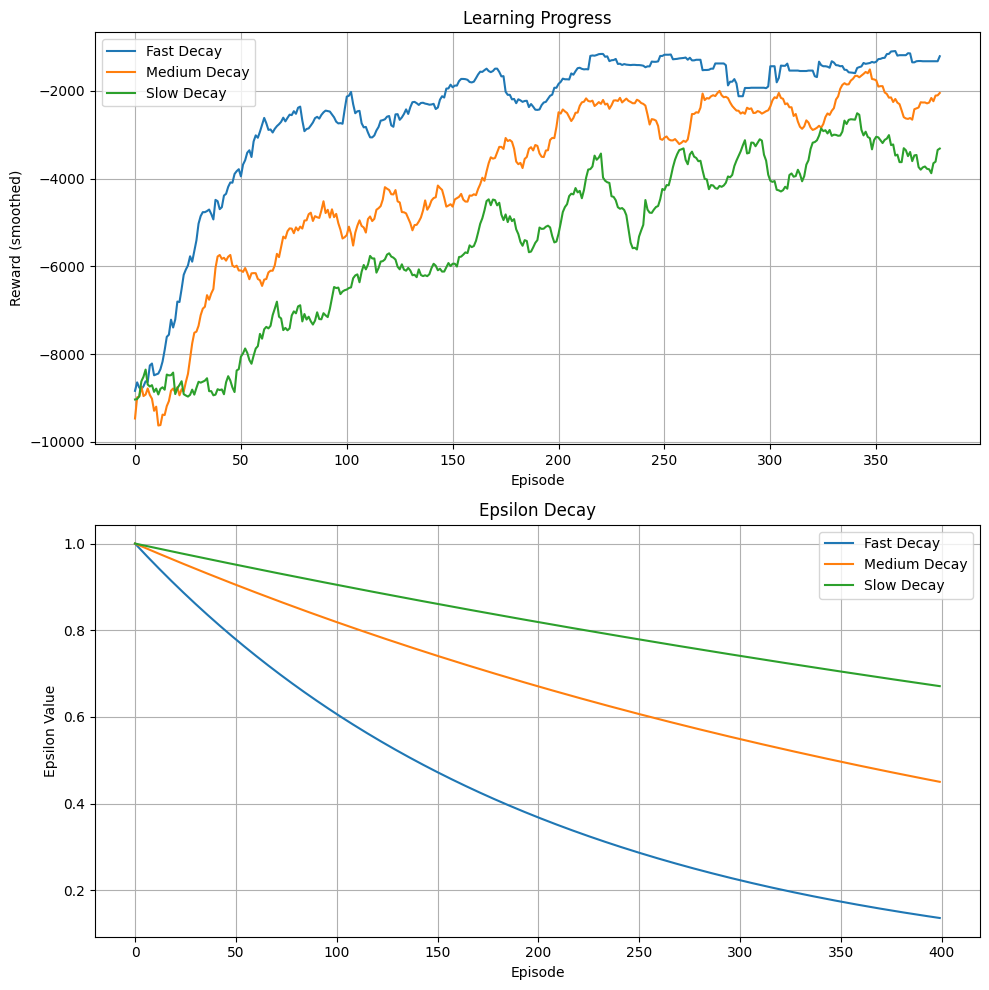

In [ ]:
# @title Epsilon Decay
class EpsilonDecayStrategy:
    def __init__(self, initial_epsilon, min_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon = initial_epsilon

    def get_epsilon(self, episode):
        """Calculate epsilon using exponential decay."""
        self.epsilon = max(
            self.min_epsilon,
            self.initial_epsilon * np.exp(-self.decay_rate * episode)
        )
        return self.epsilon

class learnEnvironmentWithEpsilonStrategy:
    def __init__(self, policy, env, n_episodes, n, alpha, max_step, epsilon_strategy):
        self.policy = policy
        self.env = env
        self.n_episodes = n_episodes
        self.n = n
        self.alpha = alpha
        self.max_step = max_step
        self.epsilon_strategy = epsilon_strategy

    def learn(self, env, algorithm):
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        Q = np.zeros((n_states, n_actions))
        reward_sums = np.zeros(self.n_episodes)
        epsilon_values = np.zeros(self.n_episodes)

        for episode in range(self.n_episodes):
            state, _ = env.reset()
            episode_reward = 0
            n_step_reward = []
            states = []
            actions = []

            # Get current epsilon
            current_epsilon = self.epsilon_strategy.get_epsilon(episode)
            epsilon_values[episode] = current_epsilon

            for step in range(self.max_step):
                action = self.policy(state, Q, current_epsilon)
                states.append(state)
                actions.append(action)
                next_state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
                n_step_reward.append(reward)

                if len(n_step_reward) >= self.n:
                    Q = algorithm(
                        n_step_reward[-self.n:],
                        Q, states, actions, next_state,
                        0.95, self.n, self.alpha,
                        current_epsilon
                    )

                if terminated or truncated:
                    break

                state = next_state

            reward_sums[episode] = episode_reward

        return Q, reward_sums, epsilon_values

def plot_results(reward_sums_list, epsilon_values_list, labels):
    """Plot rewards and epsilon decay for multiple runs."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot rewards
    for rewards, label in zip(reward_sums_list, labels):
        # Smoothing the rewards
        window_size = 20
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(smoothed_rewards, label=label)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward (smoothed)')
    ax1.set_title('Learning Progress')
    ax1.legend()
    ax1.grid(True)

    # Plot epsilon decay
    for epsilons, label in zip(epsilon_values_list, labels):
        ax2.plot(epsilons, label=label)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon Value')
    ax2.set_title('Epsilon Decay')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

# Set for reproducibility
np.random.seed(42)

# Define different epsilon decay strategies
epsilon_strategies = [
    EpsilonDecayStrategy(1.0, 0.01, 0.005),  # Fast decay
    EpsilonDecayStrategy(1.0, 0.01, 0.002),  # Medium decay
    EpsilonDecayStrategy(1.0, 0.01, 0.001)   # Slow decay
]

# Parameters
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Store results for different strategies
all_rewards = []
all_epsilons = []
strategy_labels = ['Fast Decay', 'Medium Decay', 'Slow Decay']

# Run learning for each strategy
for strategy, label in zip(epsilon_strategies, strategy_labels):
    learning_algorithm = learnEnvironmentWithEpsilonStrategy(
        epsilon_greedy, env, n_episodes, n, alpha, max_step, strategy
    )
    value_sarsa, reward_sums, epsilon_values = learning_algorithm.learn(env, sarsa)
    all_rewards.append(reward_sums)
    all_epsilons.append(epsilon_values)

    print(label)
    plot_performance(env, value_sarsa, reward_sums)

    mean_reward, std_reward = evaluate_policy(env, value_sarsa)
    print(f"\n{label} SARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

# Plot results
plot_results(all_rewards, all_epsilons, strategy_labels)
plt.show()

### **Why does epsilon 0.1 have the best performance?**  
In this environment, the reward for stepping into the cliff is -100, which is highly punishing. Because of this, exploration is not highly favored, making a lower epsilon (0.1) more effective as it prioritizes safer, learned actions over risky exploration.

# N-step Sarsa and N-step Q-learning

## Effect of  n = 1


SARSA mean_reward = -17.00 +/- 0.0000



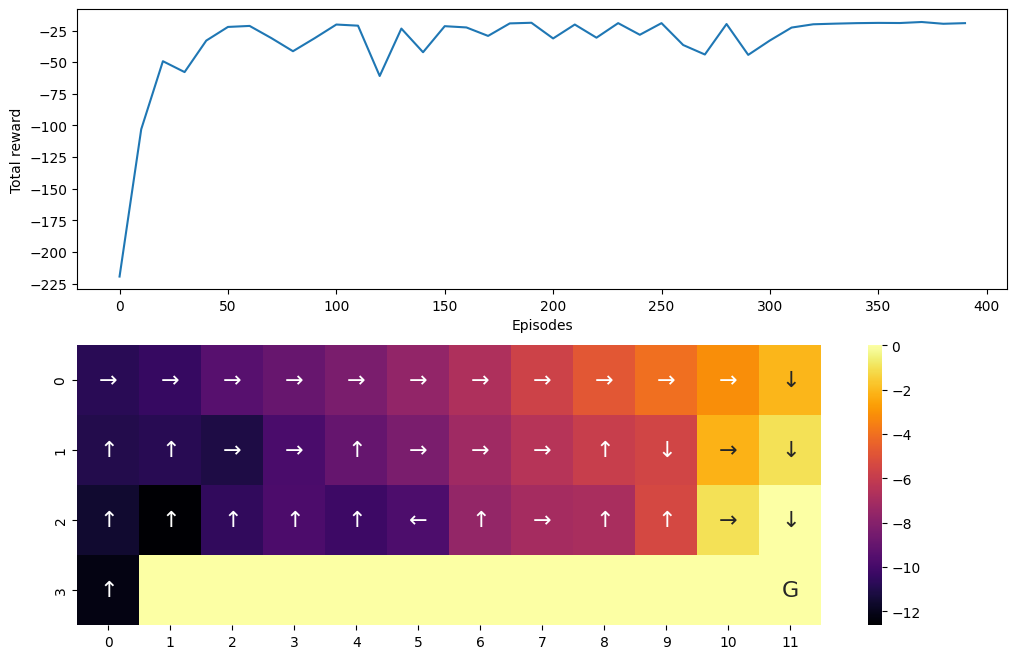

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


qlearning mean_reward = -13.00 +/- 0.0000



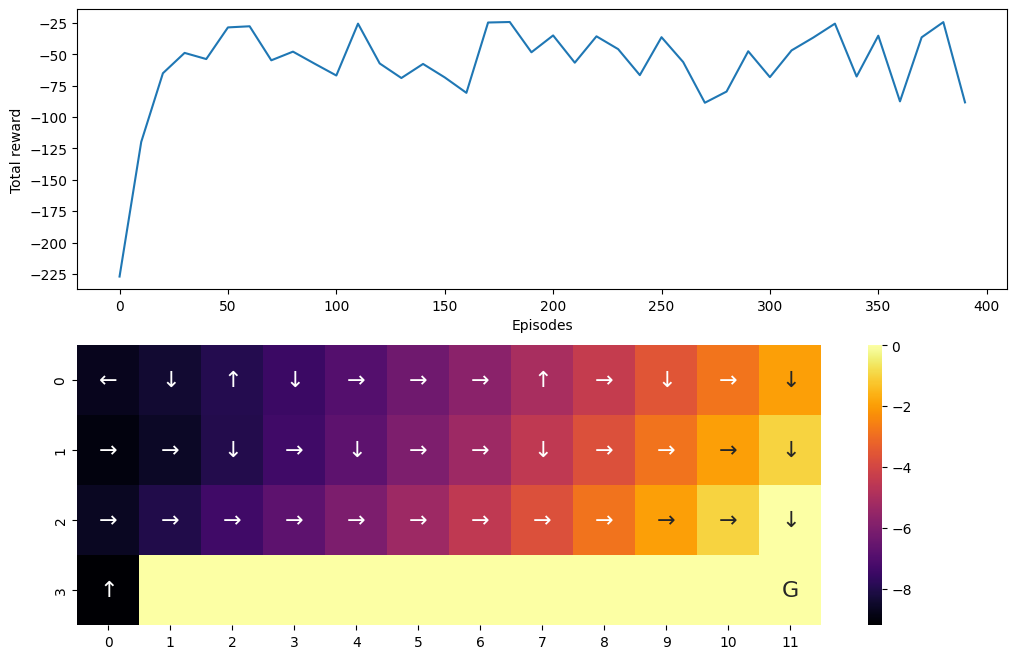

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 2


SARSA mean_reward = -17.00 +/- 0.0000



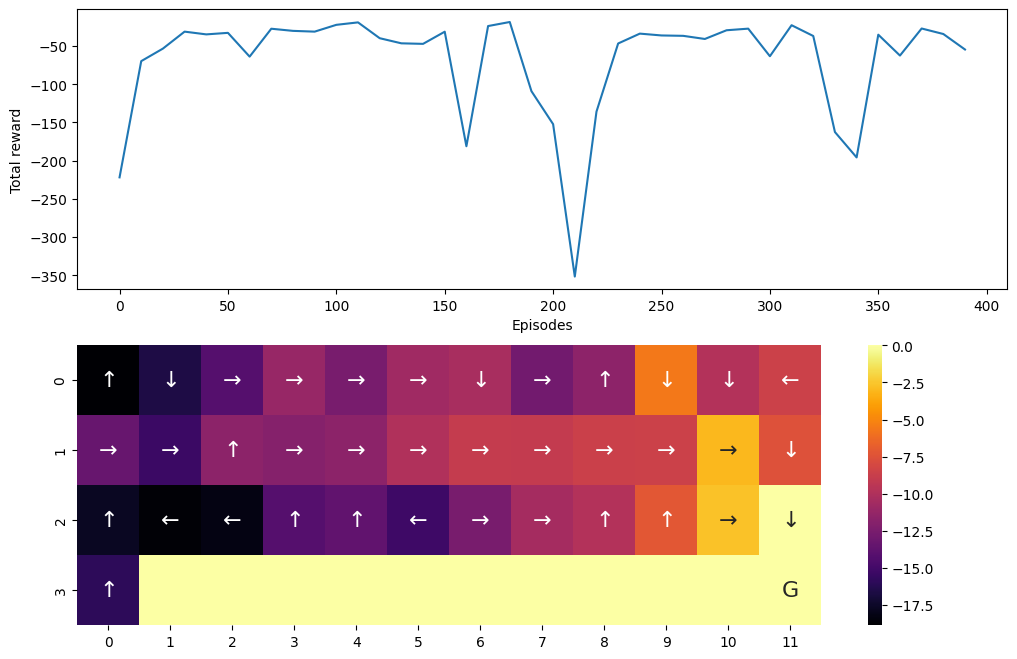

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


n_episodes = 400
n = 2
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -17.00 +/- 0.0000



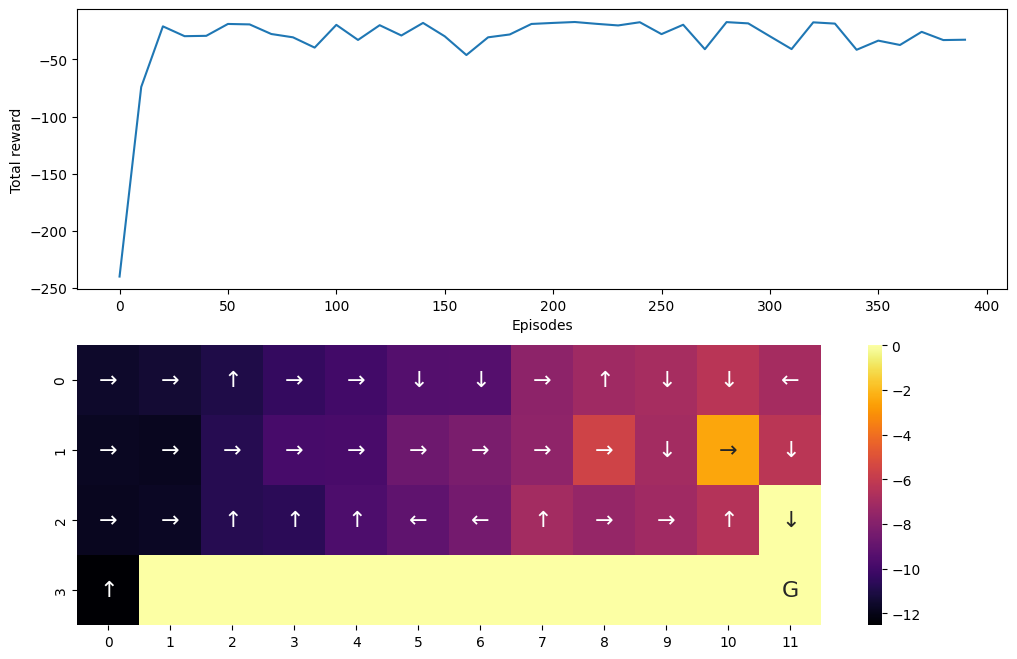

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


n_episodes = 400
n = 2
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 5


SARSA mean_reward = -17.00 +/- 0.0000



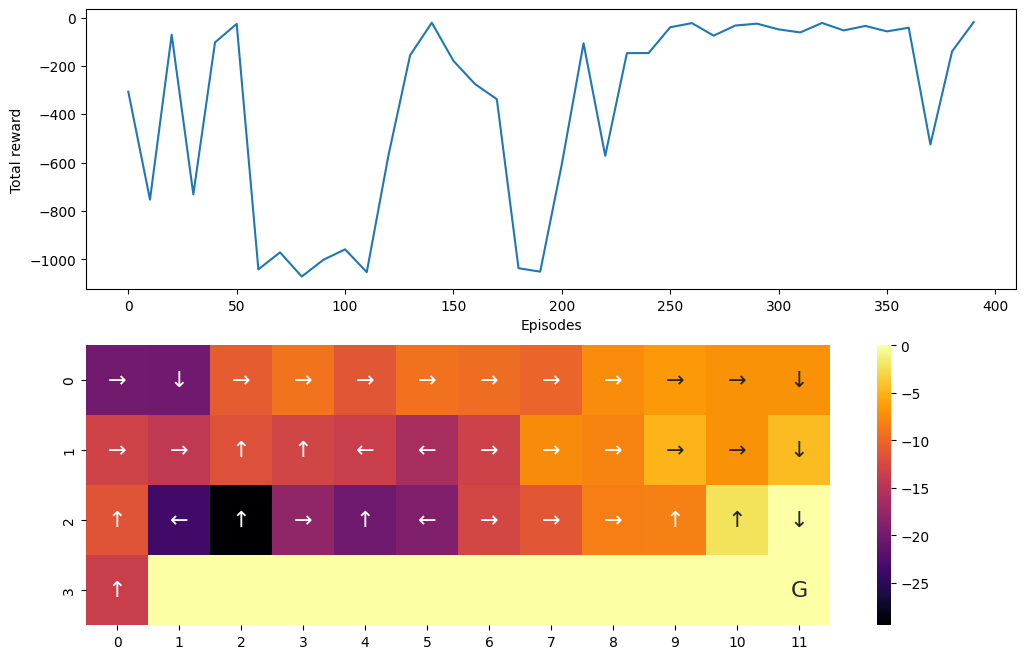

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


n_episodes = 400
n = 5
discount = 0.95
alpha = 0.5
max_step = 1000


# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -17.00 +/- 0.0000



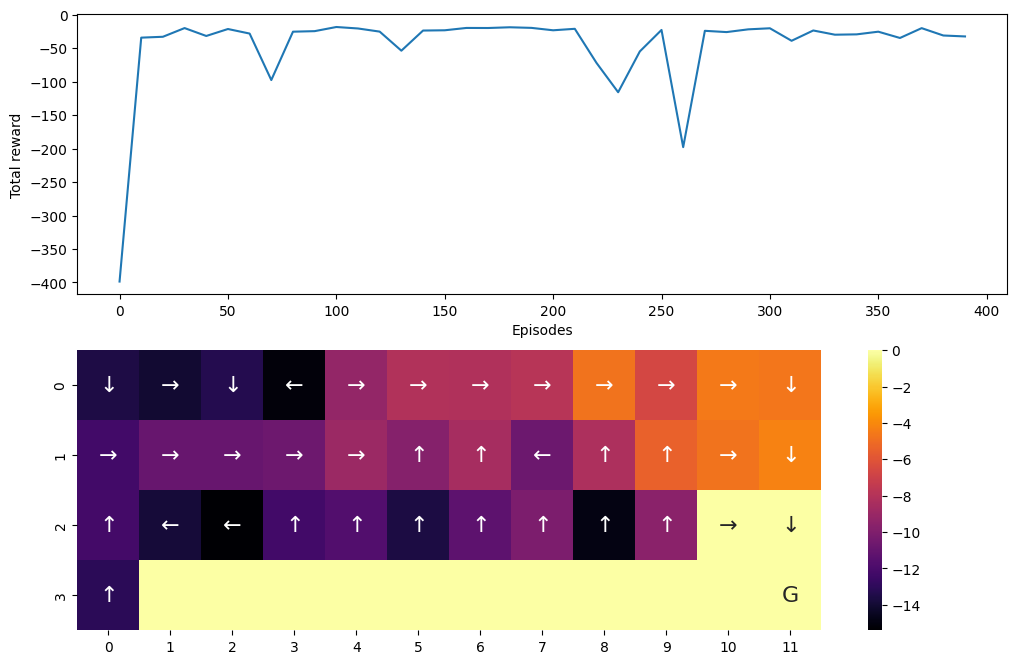

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


n_episodes = 400
n = 5
discount = 0.95
alpha = 0.5
max_step = 1000


# Initialize environment
env = gym.make('CliffWalking-v0')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results


# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)
